<div class="notebook-quickstart">
<h3>Quickstart</h3>
To run the code below:
<ol>
<li>Click on the cell to select it.</li>
<li>Press <code>SHIFT+ENTER</code> on your keyboard or press the play button
   (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above</li>
</ol>
Feel free to create new cells using the plus button
(<button class='fa fa-plus icon-plus btn btn-xs btn-default'></button>), or pressing <code>SHIFT+ENTER</code> while this cell
is selected.
</div>

This article demonstrates how a control flow, where simulation parameters depend on the results of previous simulations, can be expressed by making use of standard control structures in Python. By having access to the full expressivity of a general purpose programming language, expressing such control flow is straight-forward; this would not be the case for a declarative model description.

Our goal in this toy example is to find the threshold voltage of neuron as a function of the density of sodium channels.

This example is from our eLife paper [(Stimberg et al. 2019)](https://elifesciences.org/articles/47314).

We start with the basic setup:

In [16]:
from brian2 import *
%matplotlib notebook

defaultclock.dt = 0.01*ms  # small time step for stiff equations

Our model of the neuron is based on the classical model of from Hodgkin and Huxley (1952). Note that this is not actually a model of a neuron, but rather of a (space-clamped) axon. However, to avoid confusion with spatially extended models, we simply use the term "neuron" here. In this model, the membrane potential is shifted, i.e. the resting potential is at 0mV:

In [2]:
El = 10.613*mV
ENa = 115*mV
EK = -12*mV
gl = 0.3*msiemens/cm**2
gK = 36*msiemens/cm**2
gNa_max = 100*msiemens/cm**2
gNa_min = 15*msiemens/cm**2
C = 1*uF/cm**2

eqs = '''
dv/dt = (gl * (El-v) + gNa * m**3 * h * (ENa-v) + gK * n**4 * (EK-v)) / C : volt
gNa : siemens/meter**2
dm/dt = alpham * (1-m) - betam * m : 1
dn/dt = alphan * (1-n) - betan * n : 1
dh/dt = alphah * (1-h) - betah * h : 1
alpham = (0.1/mV) * (-v+25*mV) / (exp((-v+25*mV) / (10*mV)) - 1)/ms : Hz
betam = 4 * exp(-v/(18*mV))/ms : Hz
alphah = 0.07 * exp(-v/(20*mV))/ms : Hz
betah = 1/(exp((-v+30*mV) / (10*mV)) + 1)/ms : Hz
alphan = (0.01/mV) * (-v+10*mV) / (exp((-v+10*mV) / (10*mV)) - 1)/ms : Hz
betan = 0.125*exp(-v/(80*mV))/ms : Hz
'''

We simulate 100 neurons at the same time, each of them having a density of sodium channels between 15 and 100 mS/cm²:

In [3]:
neurons = NeuronGroup(100, eqs, method='rk4', threshold='v>50*mV')
neurons.gNa = 'gNa_min + (gNa_max - gNa_min)*1.0*i/N'

We initialize the state variables to their resting state values, note that the values for $m$, $n$, $h$ depend on the values of $\alpha_m$, $\beta_m$, etc. which themselves depend on $v$. The order of the assignments ($v$ is initialized before $m$, $n$, and $h$) therefore matters, something that is naturally expressed by stating initial values as sequential assignments to the state variables. In a declarative approach, this would be potentially ambiguous.

In [4]:
neurons.v = 0*mV
neurons.m = '1/(1 + betam/alpham)'
neurons.n = '1/(1 + betan/alphan)'
neurons.h = '1/(1 + betah/alphah)'

We record the spiking activity of the neurons and store the current network state so that we can later restore it and run another iteration of our experiment:

In [5]:
S = SpikeMonitor(neurons)
store()

The algorithm we use here to find the voltage threshold is a simple bisection: we try to find the threshold voltage of a neuron by repeatedly testing values and increasing or decreasing these values depending on whether we observe a spike or not. By continously halving the size of the correction, we quickly converge to a precise estimate.

We start with the same initial estimate for all segments, 25mV above the resting potential, and the same value for the size of the "correction step":

In [6]:
v0 = 25*mV*ones(len(neurons))
step = 25*mV

For later visualization of how the estimates converged towards their final values, we also store the intermediate values of the estimates:

In [7]:
estimates = np.full((11, len(neurons)), np.nan)*mV
estimates[0, :] = v0

We now run 10 iterations of our algorithm:

In [8]:
for i in range(10):
    # Reset to the initial state
    restore()
    # Set the membrane potential to our threshold estimate
    neurons.v = v0
    # Run the simulation for 20ms
    run(20*ms)
    # Decrease the estimates for neurons that spiked
    v0[S.count > 0] -= step
    # Increase the estimate for neurons that did not spike
    v0[S.count == 0] += step
    # Reduce step size and store current estimate
    step /= 2.0
    estimates[i + 1, :] = v0

After the 10 iteration steps, we plot the results:

<IPython.core.display.Javascript object>


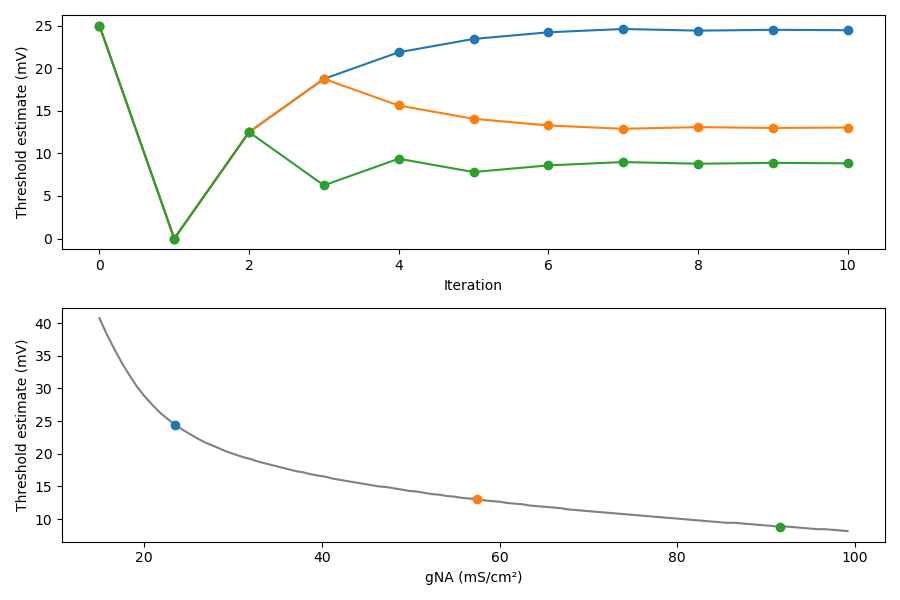

In [20]:
examples = [10, 50, 90]

figure(figsize=(9, 6))
subplot(211)
for color, example in enumerate(examples):
    plot(np.arange(11), estimates[:, example]/mV, '-', marker='o', c='C'+str(color))
xlabel('Iteration')
ylabel('Threshold estimate (mV)')
subplot(212)
plot(neurons.gNa/(mS/cm**2), v0/mV, '-', c='gray')
for color, example in enumerate(examples):
    plot([neurons.gNa[example]/(mS/cm**2)], [estimates[-1, example]/mV], 'o', c='C'+str(color))
xlabel('gNA (mS/cm²)')
ylabel('Threshold estimate (mV)')
tight_layout()